# HC model for brain applied to unhealthy

- Applying the 55 CpG site HC model to Alzheimer's and Huntington's patients
- The 55 common sites were generated using get_shared_healthy_unhealthy.ipynb and saved as brain_shared_healthy_unhealthy
- The unhealthy data was processed in get_shared_healthy_unhealthy.ipynb and saved to huntingtons/hunt_brain_55.csv for Huntington's patients and alzheimers/alz_brain_55.csv for Alzheimer's patients
- healthy/hc_brain_55CpGs.csv contains the healthy control data for the 55 shared CpG sites, generated using the healthy analysis scripts



In [1]:
import _pickle as cPickle
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt


### Reading in data: healthy

In [4]:
healthy=pd.read_csv('../healthy/hc_brain_55CpGs.csv',index_col=0)  

In [5]:
#Drop ages outside range 20-100
healthy=healthy.loc[healthy['age'] >= 20]
healthy=healthy.loc[healthy['age'] <= 110]

Text(0.5, 1.0, "Brain's healthy ages")

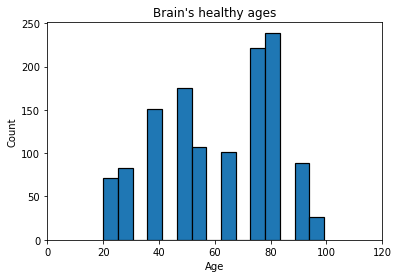

In [6]:
#Histogram of ages
counts, bins = np.histogram(healthy['age'].astype(float).astype(int))
plt.hist(bins[:-1], bins=15, weights=counts,edgecolor='black', linewidth=1.2)
plt.xlabel('Age')
plt.ylabel('Count')
plt.xlim((0,120))
plt.title("Brain's healthy ages")

### Reading in data: Huntington's

In [9]:
huntingtons_df=pd.read_csv('../huntingtons/hunt_brain_top_55.csv',index_col=0)  
#Drop ages outside range 20-100
huntingtons_df=huntingtons_df.loc[healthy['AGE'] >= 20]
huntingtons_df=huntingtons_df.loc[healthy['AGE'] <= 110]

Text(0.5, 1.0, "Huntington's brain tissue ages")

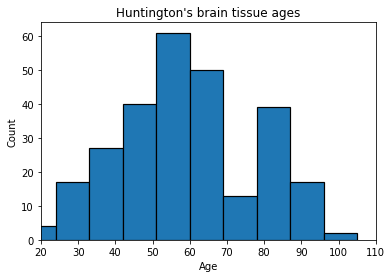

In [10]:
counts, bins = np.histogram(huntingtons_df['AGE'].astype(float).astype(int))
plt.hist(bins[:-1], bins, weights=counts,edgecolor='black', linewidth=1.2)
plt.xlabel('Age')
plt.ylabel('Count')
plt.xlim((20,110))
plt.title("Huntington's brain tissue ages")

### Reading in data: Alzheimer's

In [11]:
alzheimers_df=pd.read_csv('../alzheimers/alz_brain_top_55.csv',index_col=0)  
#Drop ages outside range 20-100
alzheimers_df=alzheimers_df.loc[healthy['AGE'] >= 20]
alzheimers_df=alzheimers_df.loc[healthy['AGE'] <= 110]

Text(0.5, 1.0, "Alzheimer's brain tissue ages")

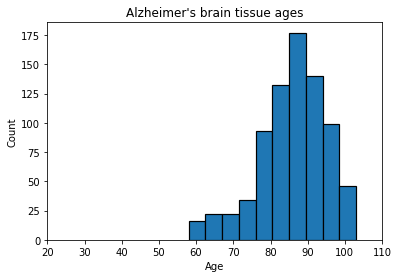

In [13]:
counts, bins = np.histogram(alzheimers_df['AGE'].astype(float).astype(int))
plt.hist(bins[:-1], bins, weights=counts,edgecolor='black', linewidth=1.2)
plt.xlabel('Age')
plt.ylabel('Count')
plt.xlim((20,110))
plt.title("Alzheimer's brain tissue ages")

In [14]:
hc_df=pd.read_csv('../healthy/hc_brain_55CpGs.csv',index_col=0)  

In [51]:
#Get any CpGs in healthy dataframe that are not in brain_shared_healthy_unhealthy file and print
#un=list(hc_df.columns)[1:]
#alz=list(alzheimers_df.columns)[1:]

#with open(r"../brain_shared_healthy_unhealthy", "rb") as input_file:
    #brain_shared_healthy_unhealthy = cPickle.load(input_file)
    
#brain_shared_healthy_unhealthy=list(brain_shared_healthy_unhealthy)
#for i in un:
    #if i not in alz:
        #print(i)

In [ ]:
hc_df=hc_df.drop(columns=['cg00050873'])   

### Reading in models

In [16]:
mod_55_brain = pd.read_pickle(r'../models/brain_mod_55')

In [17]:
mod_lasso_55_brain = pd.read_pickle(r'../models/brain_mod_lasso_55')

In [18]:
mod_ridge_55_brain = pd.read_pickle(r'../models/brain_mod_ridge_55')

In [36]:
XG_55_brain = pd.read_pickle(r'../models/brain_mod_XG_55')

In [38]:
brain_cpg_order=XG_55_brain.get_booster().feature_names

# Dealing with NAs

In [20]:
def drop_na_cols(df,percent=0.1):
    #Drop columns with >pearcent% NAs
    nas=df.isnull().sum()
    nas=nas[1:]

    for i in nas:
        if i>=len(df.index)*percent:
            try:
                df=df.drop(nas.keys()[i], axis=1)
            except KeyError:
                pass
    return df

In [21]:
def mean_impute(data):
    nas=data.isnull().sum()    
    col_means=data.mean(axis=0)
    na_cols=[]
    na_cols_means=[]

    for i in range(len(nas)):
        if nas[i]!=0:        
            na_cols.append(nas.keys()[i])
            na_cols_means.append(col_means[i])
        
    ids=list(data.index)
    for i in ids:
        for j in range(len(na_cols)):
            if str(data.loc[i][na_cols[j]])=="nan":
                data.loc[i][na_cols[j]]=na_cols_means[j]
    
    
    return data

In [22]:
#Function to apply 'model' to data X and make predictions 
#X: data with correct CpG ordering
#y: true tables
#mod_name: string e.g. 'Linear Regression'
#group: cohort name - string - e.g. 'Huntingtons'
def apply_model_and_plot(model,X,y,mod_name,group):

    # Make predictions and evaluate
    preds_y = model.predict(X)
    rms = sqrt(mean_squared_error(y, preds_y))
    r2 = r2_score(y, preds_y)
    mae = mean_absolute_error(y,preds_y)

    # Plot 

    plt.scatter(y, preds_y, alpha=0.5)
    plt.plot(range(0,120), range(0,120), c='red')
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.grid(True, lw=1.5, ls='--', alpha=0.75)
    plt.title(str(mod_name)+' on '+str(group))
    #a='rMSE:'+str(round(rms,3))
    b='MAE:'+str(round(mae,3))
    #plt.text(80, 15,'$%s$'%a,fontsize='large')
    plt.text(80, 1,'$%s$'%b,fontsize='large')
    plt.xlim((0,120))
    plt.ylim((0,175))
    plt.show()

    # print metric
    print(f'rMSE:{rms:.3f} years')
    print(f'r^2:{r2:.3f}')


In [28]:
#Getting held out healthy data sample ids
with open(r"../train_test_ids/brain_saved_sample_ids", "rb") as input_file:
    saved_ids = cPickle.load(input_file)

In [31]:
#Dropping IDs from healthy dataset which are not in held out healthy data
#Produce hc_test with this data
hc_test=hc_df
all_ids=list(hc_test.index)
for i in all_ids:
    if i not in saved_ids:
        hc_test=hc_test.drop([i])
        
hc_test

,age,cg00807959,cg01066472,cg13806070,cg15907146,cg17104258,cg24441324,cg22454769,cg23606718,cg24079702,...,cg19622662,cg23595055,cg04739123,cg16367511,cg18008766,cg19451698,cg04834794,cg07303143,cg21182694,cg23352942
GSM1443489,40.0,0.152,0.452,0.056,0.559000,0.250,0.840,0.212,0.085,0.144,...,0.232,0.898,0.038,0.083,0.073,0.044,0.023,0.231,0.193,0.602
GSM1069141,59.0,0.254,0.358,0.118,0.580000,0.096,0.794,0.359,0.168,0.267,...,0.080,0.981,0.041,0.140,0.057,0.054,0.076,0.319,0.219,0.485
GSM1069172,66.0,0.270,0.382,0.183,0.652000,0.072,0.874,0.376,0.176,0.291,...,0.121,0.955,0.047,0.136,0.097,0.099,0.033,0.284,0.232,0.562
GSM1443533,66.0,0.270,0.382,0.183,0.652000,0.072,0.874,0.376,0.176,0.291,...,0.121,0.955,0.047,0.136,0.097,0.099,0.033,0.284,0.232,0.562
GSM1443763,67.0,0.212,0.354,0.116,0.629000,0.046,0.875,0.295,0.127,0.269,...,0.053,0.962,0.053,0.135,0.081,0.061,0.091,0.221,0.198,0.475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1438289,53.0,0.317,0.619,0.138,0.578000,0.260,0.881,0.387,0.180,0.261,...,0.224,0.940,0.030,0.212,0.068,0.029,0.051,0.310,0.220,0.537
GSM1546425,53.0,0.215,0.498,0.128,0.624000,0.216,0.900,0.134,0.152,0.065,...,0.190,0.971,0.040,0.084,0.062,0.047,0.053,0.184,0.189,0.742
GSM1572948,53.0,0.224,0.207,0.138,0.596163,0.058,0.883,0.130,0.148,0.223,...,0.034,0.985,0.054,0.130,0.076,0.027,0.053,0.209,0.186,0.473
GSM1871586,53.0,0.224,0.207,0.138,0.596163,0.058,0.883,0.130,0.148,0.223,...,0.034,0.985,0.054,0.130,0.076,0.027,0.053,0.209,0.186,0.473


In [39]:
#Re-ordering columns based in brain cpg order
hc_test = hc_test[['age']+brain_cpg_order]
hc_test

,age,cg01066472,cg18514820,cg21182694,cg11236550,cg24369989,cg15731815,cg04845871,cg15341124,cg16367511,...,cg06829968,cg23595055,cg04098194,cg15463803,cg24441324,cg14911690,cg07227926,cg25090514,cg23995914,cg03169557
GSM1443489,40.0,0.452,0.061,0.193,0.314,0.441,0.057,0.032,0.188,0.083,...,0.076,0.898,0.023,0.132,0.840,0.087,0.063,0.097,0.286,0.886
GSM1069141,59.0,0.358,0.077,0.219,0.082,0.448,0.098,0.055,0.223,0.140,...,0.105,0.981,0.022,0.136,0.794,0.195,0.086,0.129,0.360,0.920
GSM1069172,66.0,0.382,0.082,0.232,0.133,0.548,0.133,0.089,0.287,0.136,...,0.091,0.955,0.009,0.156,0.874,0.204,0.080,0.152,0.407,0.946
GSM1443533,66.0,0.382,0.082,0.232,0.133,0.548,0.133,0.089,0.287,0.136,...,0.091,0.955,0.009,0.156,0.874,0.204,0.080,0.152,0.407,0.946
GSM1443763,67.0,0.354,0.065,0.198,0.054,0.546,0.112,0.044,0.238,0.135,...,0.076,0.962,0.011,0.140,0.875,0.211,0.084,0.119,0.384,0.974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1438289,53.0,0.619,0.160,0.220,0.214,0.466,0.086,0.039,0.211,0.212,...,0.129,0.940,0.021,0.122,0.881,0.146,0.185,0.176,0.287,0.954
GSM1546425,53.0,0.498,0.078,0.189,0.167,0.443,0.077,0.041,0.217,0.084,...,0.054,0.971,0.027,0.128,0.900,0.164,0.073,0.156,0.287,0.973
GSM1572948,53.0,0.207,0.169,0.186,0.015,0.386,0.091,0.028,0.185,0.130,...,0.057,0.985,0.021,0.135,0.883,0.188,0.079,0.135,0.273,0.986
GSM1871586,53.0,0.207,0.169,0.186,0.015,0.386,0.091,0.028,0.185,0.130,...,0.057,0.985,0.021,0.135,0.883,0.188,0.079,0.135,0.273,0.986


### Applying HC model to HC held out data

In [40]:
X_hc = mean_impute(hc_test.iloc[:, 1:])
y_hc = hc_test[['age']]

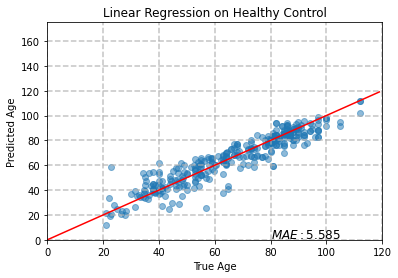

rMSE:7.687 years
r^2:0.865


In [41]:
### Linear Regression
apply_model_and_plot(mod_55_brain,X_hc,y_hc,'Linear Regression',"Healthy Control")

### Applying HC model to Alzheimer's cohort

In [44]:
alzheimers_df=alzheimers_df[['AGE']+brain_cpg_order]
alzheimers_df

,AGE,cg01066472,cg18514820,cg21182694,cg11236550,cg24369989,cg15731815,cg04845871,cg15341124,cg16367511,...,cg06829968,cg23595055,cg04098194,cg15463803,cg24441324,cg14911690,cg07227926,cg25090514,cg23995914,cg03169557
GSM1068826,88.0,0.512,0.082,0.243,0.026,0.713,0.169,0.017,0.220,0.044,...,0.091,0.972,0.004,0.140,0.846,0.088,0.060,0.086,0.176,0.969
GSM1068827,92.0,0.519,0.116,0.265,0.019,0.554,0.187,0.029,0.199,0.125,...,0.098,0.959,0.004,0.123,0.811,0.094,0.060,0.094,0.289,0.997
GSM1068829,93.0,0.620,0.141,0.329,0.028,0.617,0.226,0.019,0.199,0.193,...,0.120,0.968,0.002,0.147,0.819,0.082,0.060,0.114,0.241,0.999
GSM1068832,96.0,0.549,0.135,0.317,0.040,0.626,0.187,0.012,0.170,0.290,...,0.058,0.980,0.003,0.136,0.871,0.106,0.066,0.121,0.214,0.986
GSM1068833,86.0,0.287,0.101,0.236,0.028,0.679,0.125,0.017,0.156,0.189,...,0.066,0.981,0.005,0.111,0.863,0.055,0.060,0.077,0.171,0.994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM2809060,80.0,0.635,0.157,0.184,0.083,0.544,0.134,0.047,0.261,0.153,...,0.138,0.950,0.019,0.185,0.910,0.209,0.085,0.207,0.372,0.974
GSM2809061,70.0,0.520,0.102,0.214,0.268,0.476,0.137,0.079,0.217,0.117,...,0.138,0.910,0.038,0.118,0.887,0.222,0.090,0.208,0.337,0.928
GSM2809062,75.0,0.321,0.070,0.209,0.054,0.547,0.087,0.074,0.272,0.161,...,0.133,0.943,0.017,0.140,0.892,0.155,0.098,0.214,0.380,0.979
GSM2809063,79.0,0.537,0.069,0.220,0.068,0.557,0.137,0.050,0.291,0.117,...,0.138,0.935,0.023,0.173,0.895,0.239,0.177,0.196,0.357,0.985


In [45]:
X_alz = mean_impute(alzheimers_df.iloc[:, 1:])
y_alz = alzheimers_df[['AGE']]

### Linear Regression

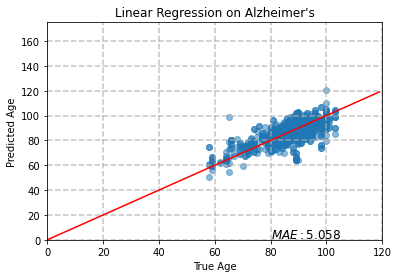

rMSE:6.803 years
r^2:0.436


In [46]:
apply_model_and_plot(mod_55_brain,X_alz,y_alz,'Linear Regression',"Alzheimer's")

### Lasso

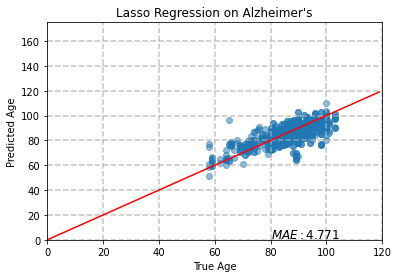

rMSE:6.426 years
r^2:0.497


In [47]:
apply_model_and_plot(mod_lasso_55_brain,X_alz,y_alz,'Lasso Regression',"Alzheimer's")

### Ridge

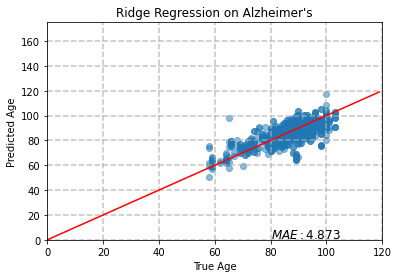

rMSE:6.543 years
r^2:0.478


In [48]:
apply_model_and_plot(mod_ridge_55_brain,X_alz,y_alz,'Ridge Regression',"Alzheimer's")

### Applying HC model to Huntington's cohort

In [51]:
huntingtons_df=huntingtons_df[['AGE']+brain_cpg_order]
huntingtons_df

,AGE,cg01066472,cg18514820,cg21182694,cg11236550,cg24369989,cg15731815,cg04845871,cg15341124,cg16367511,...,cg06829968,cg23595055,cg04098194,cg15463803,cg24441324,cg14911690,cg07227926,cg25090514,cg23995914,cg03169557
GSM1871451,83.0,0.432,0.076,0.221,0.135,0.489,0.352,0.019,0.270,0.166,...,0.135,0.981,0.016,0.121,0.926,0.173,0.084,0.164,0.367,0.988
GSM1871457,48.0,0.554,0.085,0.227,0.192,0.409,0.167,0.070,0.182,0.126,...,0.039,0.968,0.025,0.107,0.909,0.126,0.079,0.128,0.267,0.946
GSM1871498,51.0,0.248,0.057,0.239,0.207,0.436,0.118,0.055,0.184,0.170,...,0.119,0.914,0.018,0.109,0.920,0.199,0.083,0.133,0.269,0.934
GSM1871545,65.0,0.470,0.077,0.311,0.157,0.423,0.180,0.056,0.195,0.177,...,0.116,0.954,0.021,0.109,0.888,0.205,0.098,0.164,0.318,0.966
GSM1871590,67.0,0.586,0.071,0.186,0.133,0.464,0.238,0.049,0.212,0.189,...,0.055,0.964,0.017,0.115,0.881,0.165,0.089,0.148,0.343,0.976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1871815,56.0,0.244,0.147,0.181,0.092,0.478,0.066,0.035,0.193,0.112,...,0.106,0.959,0.024,0.128,0.919,0.132,0.081,0.112,0.275,0.971
GSM1871849,62.0,0.433,0.161,0.211,0.044,0.457,0.058,0.043,0.242,0.141,...,0.124,0.969,0.022,0.127,0.845,0.155,0.094,0.152,0.272,0.988
GSM1871852,58.0,0.449,0.143,0.176,0.154,0.487,0.089,0.051,0.203,0.141,...,0.103,0.935,0.019,0.113,0.917,0.173,0.171,0.142,0.281,0.990
GSM1871860,91.0,0.657,0.158,0.237,0.024,0.528,0.090,0.015,0.265,0.154,...,0.136,0.983,0.009,0.129,0.902,0.173,0.180,0.164,0.346,0.980


In [52]:
X_hunt = mean_impute(huntingtons_df.iloc[:, 1:])
y_hunt = huntingtons_df[['AGE']]

### Linear Regression

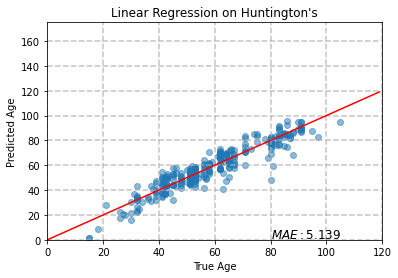

rMSE:6.649 years
r^2:0.862


In [53]:
apply_model_and_plot(mod_55_brain,X_hunt,y_hunt,'Linear Regression',"Huntington's")

### Lasso

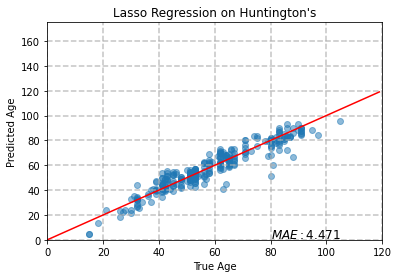

rMSE:5.926 years
r^2:0.891


In [54]:
apply_model_and_plot(mod_lasso_55_brain,X_hunt,y_hunt,'Lasso Regression',"Huntington's")

### Ridge

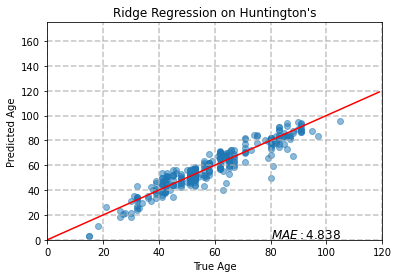

rMSE:6.259 years
r^2:0.878


In [55]:
apply_model_and_plot(mod_ridge_55_brain,X_hunt,y_hunt,'Ridge Regression',"Huntington's")